# Transfer Learning in TensorFlow Part 1: Feature extraction

### Creating helper functions

In [1]:
!wget https://raw.githubusercontent.com/LucasCarmusciano/TensorFlow-Practice/main/extras/helper_functions.py

--2024-01-08 15:15:52--  https://raw.githubusercontent.com/LucasCarmusciano/TensorFlow-Practice/main/extras/helper_functions.py
Resolviendo raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Conectando con raw.githubusercontent.com (raw.githubusercontent.com)[185.199.109.133]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 10245 (10K) [text/plain]
Grabando a: «helper_functions.py»

helper_functions.py 100%[===================>]  10.00K  --.-KB/s    en 0.001s  

2024-01-08 15:15:53 (15.9 MB/s) - «helper_functions.py» guardado [10245/10245]



In [2]:
# Import helper functions we've going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Get data

I'm gonna use pretrained models within *tf.keras.applications* and apply them to the problem (recognizing images of food).

**more info: https://www.tensorflow.org/api_docs/python/tf/keras/applications**

In [3]:
# Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2024-01-08 15:15:58--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolviendo storage.googleapis.com (storage.googleapis.com)... 142.251.133.27, 142.251.134.91, 172.217.172.91, ...
Conectando con storage.googleapis.com (storage.googleapis.com)[142.251.133.27]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 168546183 (161M) [application/zip]
Grabando a: «10_food_classes_10_percent.zip»

10_food_classes_10_ 100%[===================>] 160.74M  12.0MB/s    en 17s     

2024-01-08 15:16:15 (9.67 MB/s) - «10_food_classes_10_percent.zip» guardado [168546183/168546183]



In [4]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 1 images in '10_food_classes_10_percent'.
There are 10 directories and 1 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test

In [5]:
import tensorflow as tf

train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Let's use "tf.keras.preprocessing.image_dataset_from_directory"
# (prevously I use "tf.keras.preprocessing.image.ImageDataGenerator")
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [6]:
# Check out the class names of our dataset
train_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [8]:
# See an example of a batch of data
for images, labels in train_data.take(1): # takes the first batch to see images and labels
  print(images, labels)

tf.Tensor(
[[[[1.18000000e+02 8.10000000e+01 5.50000000e+01]
   [1.30806122e+02 9.08061218e+01 6.58061218e+01]
   [1.42219391e+02 9.97908173e+01 7.55765305e+01]
   ...
   [1.86377201e+01 1.62091923e+01 1.70561466e+01]
   [1.51683464e+01 1.53112297e+01 1.52397881e+01]
   [1.61275978e+01 1.71275978e+01 1.91275978e+01]]

  [[1.12168365e+02 7.61683655e+01 5.21683655e+01]
   [1.23923470e+02 8.57244949e+01 6.27908173e+01]
   [1.37214294e+02 9.45867386e+01 7.07704163e+01]
   ...
   [2.19591808e+01 1.71275520e+01 2.10714283e+01]
   [1.78571301e+01 1.61326637e+01 1.89948978e+01]
   [1.69540844e+01 1.60969410e+01 2.10255127e+01]]

  [[1.05790817e+02 6.92959137e+01 4.88571434e+01]
   [1.16500000e+02 7.85000000e+01 5.75306129e+01]
   [1.28642868e+02 8.60000000e+01 6.42142868e+01]
   ...
   [3.28316307e+01 1.95459137e+01 2.23520718e+01]
   [3.24999886e+01 2.05714417e+01 2.36428566e+01]
   [2.91325340e+01 2.01326389e+01 2.19183178e+01]]

  ...

  [[1.32142639e+01 1.32142639e+01 1.32142639e+01]
   [1

----
# Modeling experiments I’m running
----

<table style="font-size: 17px;">
  <tr>
    <th style="text-align: center;">Experiment</th>
    <th style="text-align: center;">Data</th> 
    <th style="text-align: center;">Preprocessing</th>
    <th style="text-align: center;">Model</th>
  </tr>
  <tr>
    <td style="text-align: center;">Model 0 (baseline)</td>
    <td style="text-align: center;">10 classes of Food101 data (<span style="font-weight: bold;">random 10%</span> training data only)</td> 
    <td style="text-align: center;">None</td>
      <td style="text-align: center;"><span style="font-weight: bold;">Feature Extractor:</span> EfficientNetB0 (pre-trained on ImageNet, all layers frozen)<span style="font-weight: bold;"> with no top</span></td>
  </tr>
  <tr>
    <td style="text-align: center;">Model 1</td>
    <td style="text-align: center;">10 classes of Food101 data (<span style="font-weight: bold;">random 1%</span> training data only)</td> 
    <td style="text-align: center;">Random Flip, Rotation, Zoom, Height, Width data augmentation</td>
      <td style="text-align: center;">Same as Model 0</td>
  </tr>
  <tr>
    <td style="text-align: center;">Model 2</td>
    <td style="text-align: center;">Same as Model 0</td> 
    <td style="text-align: center;">Same as Model 1</td>
      <td style="text-align: center;">Same as Model 0</td>
  </tr>
  <tr>
    <td style="text-align: center;">Model 3</td>
    <td style="text-align: center;">Same as Model 0</td> 
    <td style="text-align: center;">Same as Model 1</td>
      <td style="text-align: center;"><span style="font-weight: bold;">Fine-tuning:</span> Model 2 (EfficientNetB0 pre-trained on ImageNet)<span style="font-weight: bold;">with top layer trained on custom data, top 10 layers unfrozen</span></td>
  </tr>
  <tr>
    <td style="text-align: center;">Model 4</td>
    <td style="text-align: center;">10 classes of Food101 data (<span style="font-weight: bold;">100%</span> training data)</td>
    <td style="text-align: center;">Same as Model 1</td>
    <td style="text-align: center;">Same as Model 3</td>
  </tr>
</table>

## Model 0: Building a transfer learning feature extraction model using the Keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order - https://www.tensorflow.org/guide/keras/sequential_model

But the functional API gives us more flexibility with our models - https://www.tensorflow.org/guide/keras/functional

In [9]:

# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False 

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using a model like ResNet50V2 you will need to normalize inputs (you don't have to for EfficientNet(s))
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important infromation, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)


In [11]:
# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=["accuracy"])

# 10. Fit the model and save its history
history_10_percent = model_0.fit(train_data,
                                 epochs=5,
                                 steps_per_epoch=len(train_data),
                                 validation_data=test_data,
                                 validation_steps=int(0.25 * len(test_data)), # because I've actually got more test data than train data
                                 callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                        experiment_name="10_percent_feature_extraction")])

Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20240108-152101
Epoch 1/5
24/24 [==============================] - 17s 664ms/step - loss: 1.8513 - accuracy: 0.4213 - val_loss: 1.2873 - val_accuracy: 0.7270
Epoch 2/5
24/24 [==============================] - 15s 630ms/step - loss: 1.0786 - accuracy: 0.7587 - val_loss: 0.8791 - val_accuracy: 0.8076
Epoch 3/5
24/24 [==============================] - 15s 638ms/step - loss: 0.7745 - accuracy: 0.8293 - val_loss: 0.7108 - val_accuracy: 0.8405
Epoch 4/5
24/24 [==============================] - 15s 638ms/step - loss: 0.6351 - accuracy: 0.8693 - val_loss: 0.6341 - val_accuracy: 0.8405
Epoch 5/5
24/24 [==============================] - 16s 662ms/step - loss: 0.5368 - accuracy: 0.8773 - val_loss: 0.5779 - val_accuracy: 0.8553


In [12]:
# Evalaute on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 29s 370ms/step - loss: 0.5524 - accuracy: 0.8648


[0.5523791313171387, 0.864799976348877]

In [13]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, None, None, 3)        0         ['normalization[0

 y)                                                                  'block2a_se_expand[0][0]']   
                                                                                                  
 block2a_project_conv (Conv  (None, None, None, 24)       2304      ['block2a_se_excite[0][0]']   
 2D)                                                                                              
                                                                                                  
 block2a_project_bn (BatchN  (None, None, None, 24)       96        ['block2a_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block2b_expand_conv (Conv2  (None, None, None, 144)      3456      ['block2a_project_bn[0][0]']  
 D)                                                                                               
          

                                                                                                  
 block3a_project_conv (Conv  (None, None, None, 40)       5760      ['block3a_se_excite[0][0]']   
 2D)                                                                                              
                                                                                                  
 block3a_project_bn (BatchN  (None, None, None, 40)       160       ['block3a_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block3b_expand_conv (Conv2  (None, None, None, 240)      9600      ['block3a_project_bn[0][0]']  
 D)                                                                                               
                                                                                                  
 block3b_e

 block4a_project_conv (Conv  (None, None, None, 80)       19200     ['block4a_se_excite[0][0]']   
 2D)                                                                                              
                                                                                                  
 block4a_project_bn (BatchN  (None, None, None, 80)       320       ['block4a_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block4b_expand_conv (Conv2  (None, None, None, 480)      38400     ['block4a_project_bn[0][0]']  
 D)                                                                                               
                                                                                                  
 block4b_expand_bn (BatchNo  (None, None, None, 480)      1920      ['block4b_expand_conv[0][0]'] 
 rmalizati

 ormalization)                                                                                    
                                                                                                  
 block4c_drop (Dropout)      (None, None, None, 80)       0         ['block4c_project_bn[0][0]']  
                                                                                                  
 block4c_add (Add)           (None, None, None, 80)       0         ['block4c_drop[0][0]',        
                                                                     'block4b_add[0][0]']         
                                                                                                  
 block5a_expand_conv (Conv2  (None, None, None, 480)      38400     ['block4c_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block5a_e

 block5b_add (Add)           (None, None, None, 112)      0         ['block5b_drop[0][0]',        
                                                                     'block5a_project_bn[0][0]']  
                                                                                                  
 block5c_expand_conv (Conv2  (None, None, None, 672)      75264     ['block5b_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block5c_expand_bn (BatchNo  (None, None, None, 672)      2688      ['block5c_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block5c_expand_activation   (None, None, None, 672)      0         ['block5c_expand_bn[0][0]']   
 (Activati

 ormalization)                                                                                    
                                                                                                  
 block6b_expand_conv (Conv2  (None, None, None, 1152)     221184    ['block6a_project_bn[0][0]']  
 D)                                                                                               
                                                                                                  
 block6b_expand_bn (BatchNo  (None, None, None, 1152)     4608      ['block6b_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block6b_expand_activation   (None, None, None, 1152)     0         ['block6b_expand_bn[0][0]']   
 (Activation)                                                                                     
          

 block6c_add (Add)           (None, None, None, 192)      0         ['block6c_drop[0][0]',        
                                                                     'block6b_add[0][0]']         
                                                                                                  
 block6d_expand_conv (Conv2  (None, None, None, 1152)     221184    ['block6c_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block6d_expand_bn (BatchNo  (None, None, None, 1152)     4608      ['block6d_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block6d_expand_activation   (None, None, None, 1152)     0         ['block6d_expand_bn[0][0]']   
 (Activati

                                                                                                  
 top_bn (BatchNormalization  (None, None, None, 1280)     5120      ['top_conv[0][0]']            
 )                                                                                                
                                                                                                  
 top_activation (Activation  (None, None, None, 1280)     0         ['top_bn[0][0]']              
 )                                                                                                
                                                                                                  
Total params: 4049571 (15.45 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 4049571 (15.45 MB)
__________________________________________________________________________________________________


In [14]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062381 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049571 (15.45 MB)
__________________

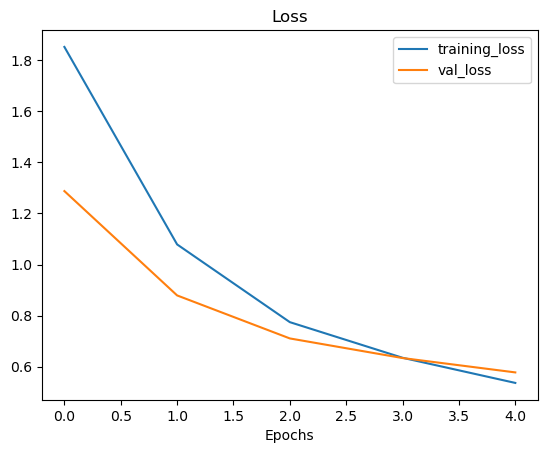

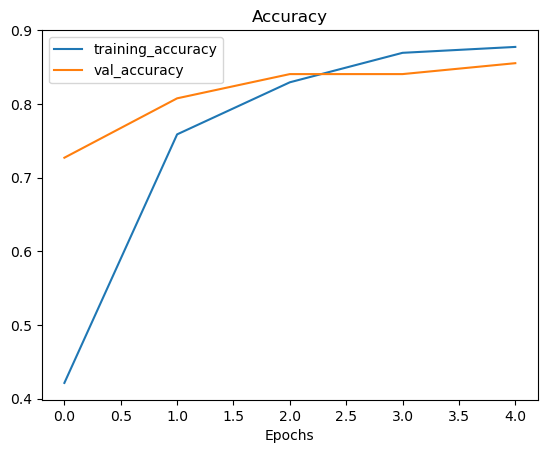

In [15]:
plot_loss_curves(history_10_percent)

---
## Model 1: Use feature extraction transfer learning with 1% of the training data (with data augmentation)

In [16]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip 
unzip_data("10_food_classes_1_percent.zip")

--2024-01-08 15:34:45--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolviendo storage.googleapis.com (storage.googleapis.com)... 142.250.79.123, 142.251.133.251, 142.250.79.91, ...
Conectando con storage.googleapis.com (storage.googleapis.com)[142.250.79.123]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 133612354 (127M) [application/zip]
Grabando a: «10_food_classes_1_percent.zip»

10_food_classes_1_p 100%[===================>] 127.42M  10.8MB/s    en 13s     

2024-01-08 15:34:58 (10.0 MB/s) - «10_food_classes_1_percent.zip» guardado [133612354/133612354]



In [17]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir_1_percent = "10_food_classes_1_percent/test"

In [18]:
walk_through_dir(train_dir_1_percent)

There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.


In [19]:
# Setup data loaders 
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)

test_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir_1_percent,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


#### Building a data augmentation layer to use inside the model

To add data augmentation right into models, use the layer inside:

* `tf.keras.layers.experimental.preprocessing()`

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  # preprocessing.Rescale(1./255) # Keep for models like ResNet50V2 but EfficientNet's having resclaing built-in
], name="data_augmentation")

Now, I'll visualize a image of the augmented data

10_food_classes_1_percent/train/pizza/2705497.jpg


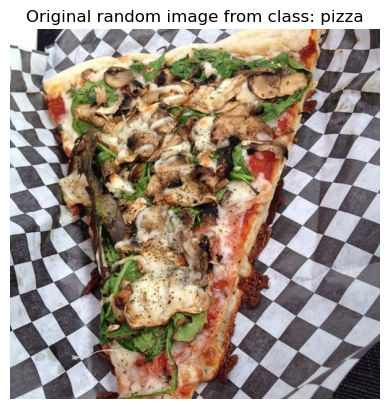

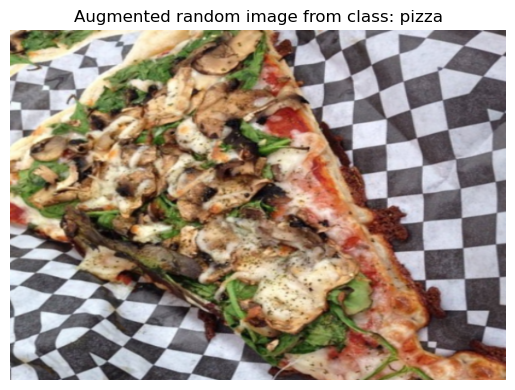

In [49]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = train_dir_1_percent + "/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image
print(random_image_path)

# Read and plot in the random image 
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False);

# Now let's plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);
# print(augmented_img)

In [50]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data_1_percent,
                                validation_steps=int(0.25 * len(test_data_1_percent)),
                                # Track model training logs
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20240109-172707
Epoch 1/5
3/3 [==============================] - 11s 4s/step - loss: 2.3185 - accuracy: 0.1286 - val_loss: 2.2230 - val_accuracy: 0.1776
Epoch 2/5
3/3 [==============================] - 8s 4s/step - loss: 2.1145 - accuracy: 0.2143 - val_loss: 2.1138 - val_accuracy: 0.2533
Epoch 3/5
3/3 [==============================] - 8s 4s/step - loss: 1.8876 - accuracy: 0.5000 - val_loss: 2.0149 - val_accuracy: 0.3289
Epoch 4/5
3/3 [==============================] - 8s 4s/step - loss: 1.6989 - accuracy: 0.5714 - val_loss: 1.9197 - val_accuracy: 0.4293
Epoch 5/5
3/3 [==============================] - 8s 4s/step - loss: 1.5390 - accuracy: 0.7286 - val_loss: 1.8207 - val_accuracy: 0.4885


In [51]:
# Evalute on the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 29s 364ms/step - loss: 1.8160 - accuracy: 0.4836


[1.8160029649734497, 0.483599990606308]

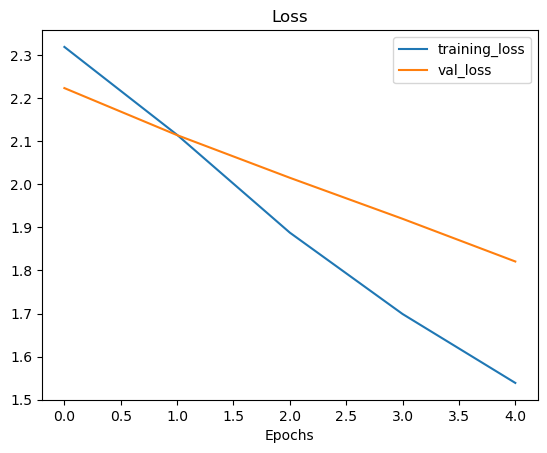

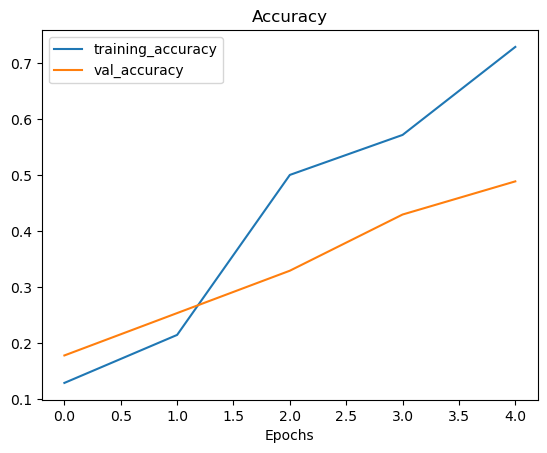

In [52]:
plot_loss_curves(history_1_percent)

---
## Model 2: feature extraction transfer learning model with 10% of data and data augmentation

In [53]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the inputs and outputs (including the layers in between)
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=["accuracy"])

### Creating a ModelCheckpoint callback

The ModelCheckpoint callback intermediately saves our model (the full model or just the weights) during training. This is useful so we can come and start where we left off.

In [54]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

### Fit model 2 (passing in the ModelCheckpoint callback)

In [55]:
# Fit the model
history_model2 = model_2.fit(train_data, # train_data has 10% of data
                                epochs=5,
                                steps_per_epoch=len(train_data),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)),
                                # Track model training logs
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="1_percent_data_aug"),
                                          checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20240109-174353
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9450 - accuracy: 0.3787
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 18s 680ms/step - loss: 1.9450 - accuracy: 0.3787 - val_loss: 1.3852 - val_accuracy: 0.6760
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.2695 - accuracy: 0.7027
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 16s 683ms/step - loss: 1.2695 - accuracy: 0.7027 - val_loss: 0.9866 - val_accuracy: 0.7549
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9770 - accuracy: 0.7613
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 15s 647ms/step - loss: 0.9770 - accuracy: 0.7613 - val_loss: 0.7825 - val_accuracy: 0.8109
Ep

In [56]:
model_0.evaluate(test_data)

79/79 [==============================] - 27s 344ms/step - loss: 0.5524 - accuracy: 0.8648


[0.5523791313171387, 0.864799976348877]

In [57]:
# Check model_2 results on all test_data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 28s 349ms/step - loss: 0.6130 - accuracy: 0.8428


[0.6130409836769104, 0.8428000211715698]

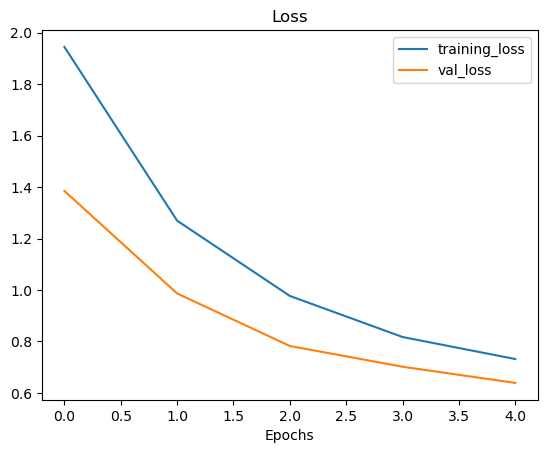

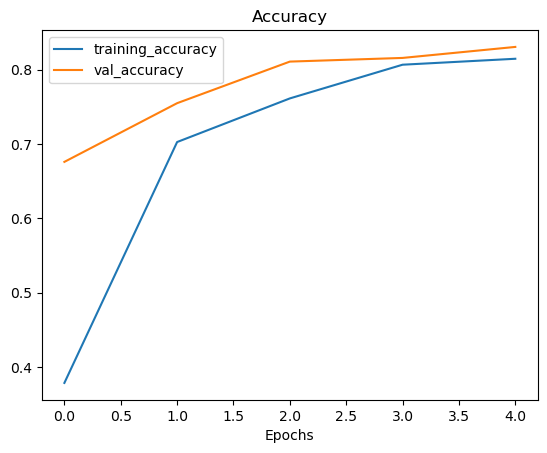

In [58]:
plot_loss_curves(history_model2)

---
## Model 3: Fine-tuning an existing model on 10% of the data

In [59]:
# Layers in loaded model (are these layers trainable?)
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x160e4feb0> True
<keras.src.engine.sequential.Sequential object at 0x286b796c0> True
<keras.src.engine.functional.Functional object at 0x164ba72e0> False
<keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x164ae7cd0> True
<keras.src.layers.core.dense.Dense object at 0x164b59990> True


In [61]:
# Check which layers are tunable (trainable)
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [64]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (we have to recompile our models every time we make a change)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

> In fine-tuning, you typically want to **lower the learning rate** by 10x (learning_rate=0.0001 when the default is 0.001)

In [68]:
# The last 10 layers are trainable!
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [70]:
# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data,
                                               epochs=10, # Fine tune for another 5 epochs (model_2 had 5 epochs)
                                               validation_data=test_data,
                                               validation_steps=int(0.25 * len(test_data)),
                                               initial_epoch=history_model2.epoch[-1], # start training from previous last epoch
                                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                      experiment_name="10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20240110-184739
Epoch 5/10
24/24 [==============================] - 18s 679ms/step - loss: 0.5782 - accuracy: 0.8347 - val_loss: 0.5300 - val_accuracy: 0.8306
Epoch 6/10
24/24 [==============================] - 17s 725ms/step - loss: 0.4762 - accuracy: 0.8467 - val_loss: 0.4911 - val_accuracy: 0.8454
Epoch 7/10
24/24 [==============================] - 16s 686ms/step - loss: 0.4275 - accuracy: 0.8653 - val_loss: 0.4823 - val_accuracy: 0.8536
Epoch 8/10
24/24 [==============================] - 17s 705ms/step - loss: 0.3769 - accuracy: 0.8827 - val_loss: 0.4538 - val_accuracy: 0.8454
Epoch 9/10
24/24 [==============================] - 17s 704ms/step - loss: 0.3214 - accuracy: 0.9160 - val_loss: 0.4682 - val_accuracy: 0.8520
Epoch 10/10
24/24 [==============================] - 17s 725ms/step - loss: 0.2965 - accuracy: 0.9027 - val_loss: 0.4379 - val_accuracy: 0.8586


In [71]:
# Evaluate the fine-tuned model (model_3 which is actualy model_2 fine-tuned for another 5 epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 30s 375ms/step - loss: 0.4205 - accuracy: 0.8636


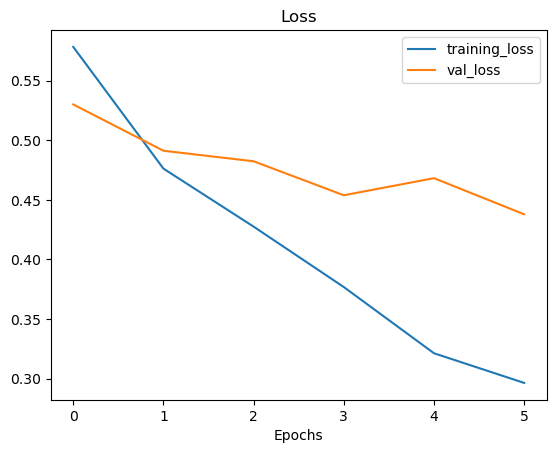

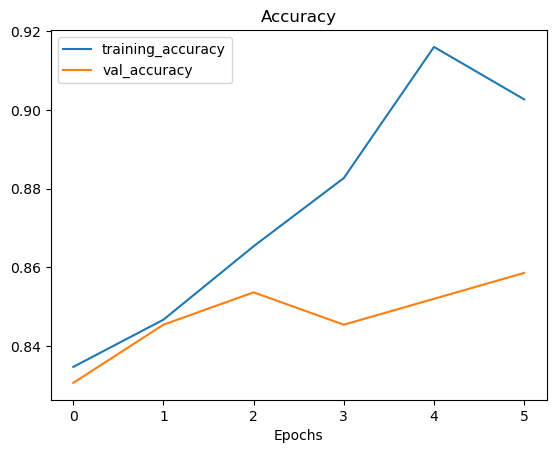

In [72]:
plot_loss_curves(history_fine_10_percent_data_aug)

The `plot_loss_curves()` function works great with models which have only been fit once, however, we want something to compare one series of running `fit()` with another (e.g. before and after fine-tuning).

In [77]:

# Let's create a function to compare training histories
def compare_historys(original_history, new_history, initial_epochs=5):
  """
  Compares two TensorFlow History objects.
  """
  # Get original history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history metrics with new_history metrics
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Make plot for accuracy
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="Val Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  # Make plot for loss
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label="Training Loss")
  plt.plot(total_val_loss, label="Val Loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="upper right")
  plt.title("Training and Validation Loss")

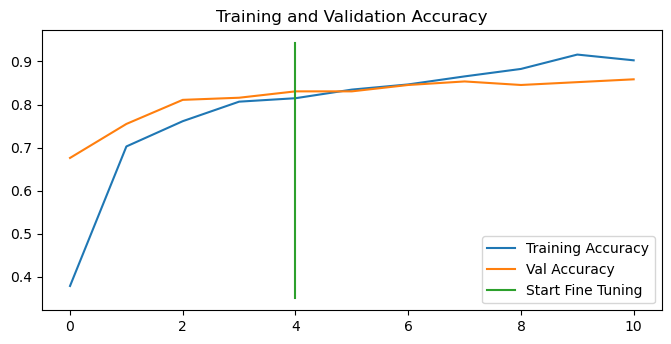

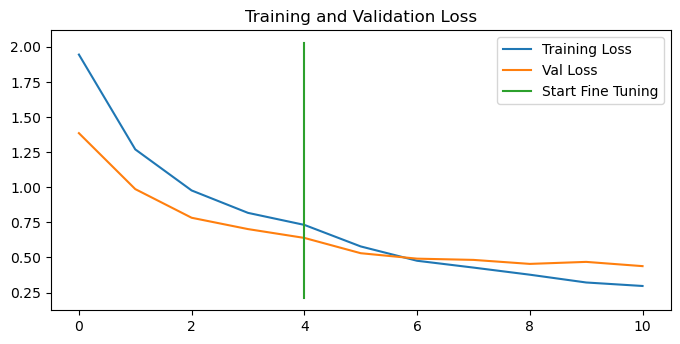

In [78]:
compare_historys(history_model2,
                 history_fine_10_percent_data_aug,
                 initial_epochs=5)

## Model 4: Fine-tuning and existing model on all of the data

In [79]:
# Download and unzip 10 classes of Food101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2024-01-10 19:50:54--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolviendo storage.googleapis.com (storage.googleapis.com)... 142.250.79.91, 142.251.133.59, 142.250.79.123, ...
Conectando con storage.googleapis.com (storage.googleapis.com)[142.250.79.91]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 519183241 (495M) [application/zip]
Grabando a: «10_food_classes_all_data.zip»

10_food_classes_all 100%[===================>] 495.13M  7.97MB/s    en 50s     

2024-01-10 19:51:45 (9.87 MB/s) - «10_food_classes_all_data.zip» guardado [519183241/519183241]

